# Compare runs

compare_runs.ipynb

This notebook runs several analysis and plots on the simulation output to compare runs to each other. 
You can plot the spatiotemporal mean over the last ```ndays``` (user input) for ice microphyiscs, 
cloud macrophysics, radiative heating profiles as well as temperature and humidity.
Temperature and humidity can also be plotted for each variable and simulation as an evolution over 
10-day means from start to finish. 



In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import warnings
import util

warnings.filterwarnings('ignore')

In [4]:
# --- begin user input ---
comp_name = "sst"
# dtperday=8  # assuming 8 timesteps per day
# 8 timesteps per day is true for the default - need to automate this for each file
ndays = 20  # number of days to plot (last ndays of simulations)
# --- end user input ---

runs, run_names, colors = util.get_comp_names(comp_name)
if (comp_name=="sst"):
    markers = ['o','v','^']
elif (comp_name=="other"):
    markers = ['o','D','x']
else:
    markers = ["o", "o", "s", "s", "D", "D", "x"]
color_hi = 1
color_hi1 = 2

# nt = ndays*dtperday+1  # number of timesteps
run_dir = "/glade/work/sturbeville/DPSCREAM_simulations/all_run_files/"

runs, run_names = ["dpscream_rce_small_3km_aa_default"], ["Default"]

# Plot spatiotemporal mean of ice characteristics

This includes 
- ```IWC``` ice water content,
- ```NI``` ice number, and
- ```RICE``` mean ice mass radius

I've enabled the options for plotting:
- ```logscale``` to plot on a logscale (for ice water content espcially in the TTL), and
- ```plot_incld``` to plot only in cloud mean values of above variables

Assumptions:
- We assume that the 3D output is 6 hourly - update ```dtperday``` above if not true

0 Default (300K)... in cloud only...IWC...NI...RICE...1 of 3 done.
1 Warm SST (304K)... in cloud only...IWC...NI...RICE...2 of 3 done.
2 Cool SST (296K)... in cloud only...IWC...NI...RICE...3 of 3 done.
saving to plots/compare_runs_IWC_NI_RICE_sstincld_.png


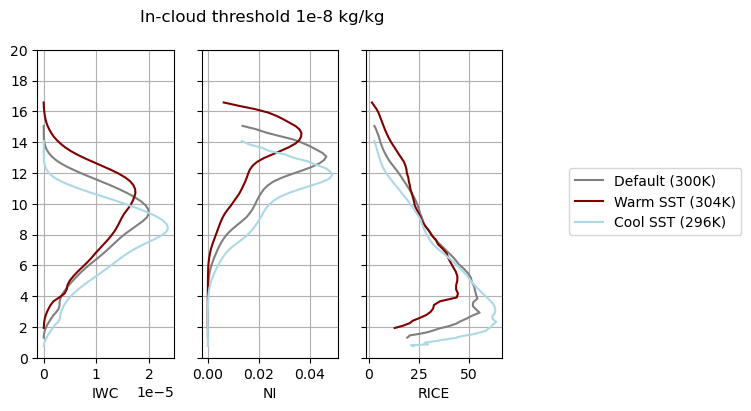

In [2]:
# ---- begin user input ----
var_list = ["IWC","NI","RICE"]
logscale=False
plot_incld = True
# ---- end user input ----

fig, ax = plt.subplots(1,len(var_list), figsize=(2*len(var_list),4), sharey=True)
savename="IWC_NI_RICE_{}".format(comp_name)
if logscale:
    xmin, xmax = 1e-8,1e-4
    ax.set_xscale("log")
    savename += "log_"
else:
    xmin, xmax = 0,0
if plot_incld:
    savename+="incld_"

for i in range(len(runs)):
    print(i, run_names[i], end="...")
    # ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i]))
    dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
    print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
    nt = ndays*dtperday
    z = ds.Z3.mean(dim=["time","ncol"])
    ntime = len(ds.time.isel(time=slice(-nt,-1)))
    ds = ds.isel(time=slice(-nt,-1))
    if "NI" in var_list:
        ni = (util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])/1e6).assign_attrs({'long_name':'icnc', 'units':'cm-3'})
        ds = ds.assign({"NI":ni})
    if "RICE" in var_list:
        rice = util.calc_rice(ds.CLDICE, ds.NUMICE)
        rice = xr.DataArray(rice, dims=ni.dims, coords=ni.coords,
                            attrs={'long_name':'mass ice radius', 'units':'micron'})
        ds = ds.assign({"RICE":rice})
    ds = ds[var_list+["CLDICE"]].mean(dim=["time","ncol"])
    if plot_incld:
        ds = ds.where(ds.CLDICE>1e-8)
        fig.suptitle("In-cloud threshold 1e-8 kg/kg")
        print(" in cloud only...", end="")
    # print(ds.variables.values, end="...")
    c = colors[i]
    a = 1
    for j,v in enumerate(var_list):
        print(v, end="...")
        ax[j].plot(ds[v], z/1000, color=c, alpha=a,
            label=run_names[i])
        ax[j].set(xlabel=v, yticks=np.arange(0,21,2), ylim=[0,20])
        ax[j].grid(True)
    print(i+1,"of",len(runs),"done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename)
print("saving to",savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()


# plot cloud macrophysics

Plots the following variables (mean over the last ```ndays``` of the simulations): 
- ```Cld frac``` cloud fraction from IWC or CLDICE (QI) defined as greater than ```qsmall = 1e-8 kg/kg```,
- ```in-cloud IWC``` in cloud ice water content, and
- ```all sky IWC``` all sky cloud ice water content

I've enabled the options for plotting:
- ```cldfrac_type``` how to calculate cld fraction from ```QI``` cloud ice (kg/kg), ```IWC``` ice water content (kg/m3), or ```CLD``` default cloud fraction output from model
- ```qsmall``` cloud threshold in kg/kg, and
- ```xmaxs``` the upper limit on the x-axis for each subplot for visual appeal

Assumptions:
- We assume that the 3D output is 6 hourly - update ```dtperday``` above if not true

saving to plots/compare_runs_QICLDFRAC_incldIWC_IWC_1e-08_sst.png


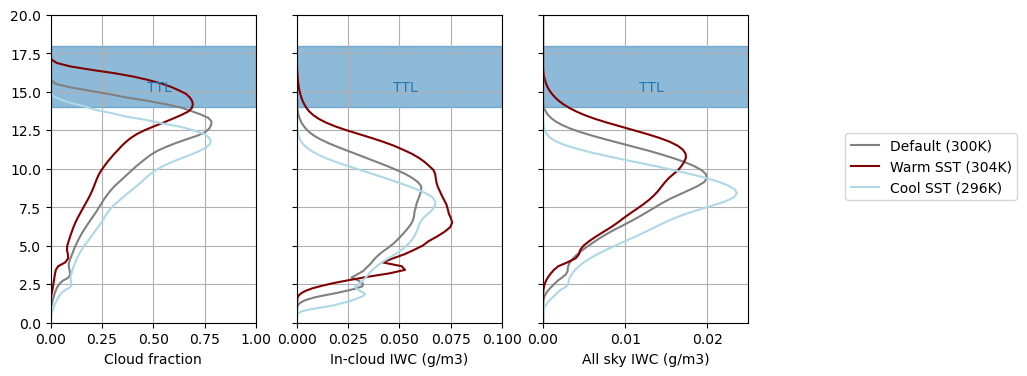

In [3]:
# --- begin user input ---
xmaxs = [1,0.1,0.025]  # xlim max values for each subplot
qsmall=1e-8  # kg/kg
cldfrac_type="QI"  # options: QI, IWC, CLD (see comments above)
# --- end user input ---

fig, ax = plt.subplots(1,3, figsize=(9,4))
savename="{}FRAC_incldIWC_IWC_{}_{}".format(cldfrac_type, str(qsmall),comp_name)
for i in range(len(runs)):
    # get cloud fraction and in-cloud mean IWC
    file = run_dir+"/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
    dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
    print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
    nt = ndays*dtperday
    ds = xr.open_dataset(file).isel(time=slice(-nt,-1))
    z = ds.Z3.mean(dim=["time","ncol"])/1000
    if cldfrac_type=="IWC":
        # defined by qsmall IWC
        ds = ds.IWC
        cld_frac = np.mean(np.where(ds>qsmall,1,0), axis=(0,2))
        incld_iwc = ds.where(ds>qsmall).mean(dim=["time","ncol"])
        del ds
    elif cldfrac_type=="QI":
        # defined by qsmall QI
        cld_frac = np.mean(np.where(ds.CLDICE>qsmall,1,0), axis=(0,2))
        incld_iwc = ds.IWC.where(ds.CLDICE>qsmall).mean(dim=["time","ncol"])
        iwc = ds.IWC.mean(dim=["time","ncol"])
        del ds
    else:
        # defined by model output of cloud fraction CLOUD
        cld_frac = ds.CLOUD.mean(dim=["time","ncol"])
        incld_iwc = ds.IWC.where(ds.CLOUD==1).mean(dim=["time","ncol"])
        del ds
    c = colors[i]
    a = 1
    # plot cld fraction, in-cld iwc, ttl in cld iwc
    ax[0].plot(cld_frac, z, color=c, alpha=a, label=run_names[i])
    ax[1].plot(incld_iwc*1000, z, color=c, alpha=a)
    ax[2].plot(iwc*1000, z, color=c, alpha=a)
    xmaxs = np.max(np.array([xmaxs,[cld_frac.max(), incld_iwc.max(),incld_iwc[28:65].max()]]), axis=0)

ax[0].set_xlabel("Cloud fraction")
ax[1].set_xlabel("In-cloud IWC (g/m3)")
ax[2].set_xlabel("All sky IWC (g/m3)")
# ax[2].set_xlabel("In-cloud TTL IWC (g/m3)")

for j in range(3):
    ax[j].grid(True)
    ax[j].fill_between([0, 1], 14, 18, color="C0", alpha=0.5)
    if j==-1:
        ax[j].annotate("TTL", color="C0", xy=(0.47,0.5), xycoords="axes fraction")
        ax[j].set_ylim([12,20])
    else:
        ax[j].annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
        ax[j].set_ylim([0,20])
    ax[j].set_xlim([0,xmaxs[j]])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
# ax[2].tick_params(labelrotation=20)
fig.legend(loc=6, bbox_to_anchor=(1.0, 0.5))
print("saving to plots/compare_runs_{}.png".format(savename))
plt.savefig("plots/compare_runs_{}.png".format(savename), dpi=120, bbox_inches="tight",pad_inches=1)
plt.show()

# Cloud radiative heating rates 

Plots the following variables (mean over the last ```ndays``` of the simulations): 
- ```QRL``` longwave cloud heating rate,
- ```QRS``` shortwave cloud heating rate, and
- Total (net) cloud heating rate (K/day)

0 Default (300K) f_default...QRL...QRS...Total heating rate (K/day)...1 of 3 done.
1 Warm SST (304K) j_304K...QRL...QRS...Total heating rate (K/day)...2 of 3 done.
2 Cool SST (296K) j_296K...QRL...QRS...Total heating rate (K/day)...3 of 3 done.
saving to plots/compare_runs_heating-rates-Kday-1_ss.png


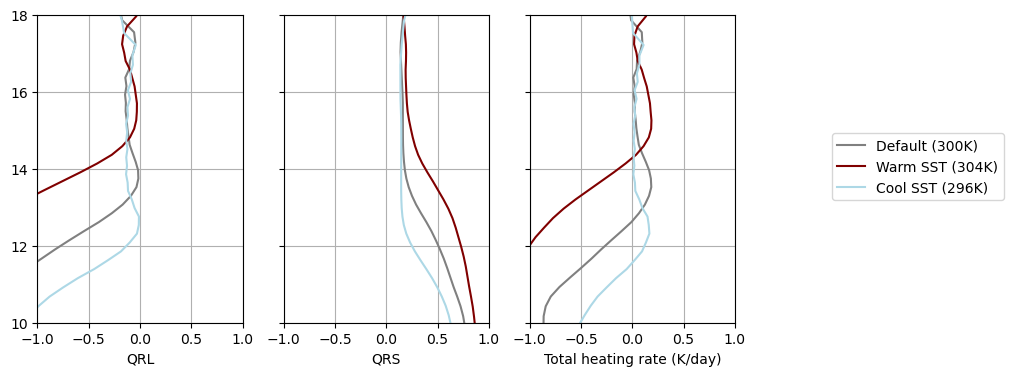

In [4]:
var_list = ["QRL","QRS","Total heating rate (K/day)"]
fig, ax = plt.subplots(1,len(var_list), figsize=(3*len(var_list),4), sharey=True)
savename="heating-rates-Kday-1_"+comp_name
xmin, xmax = 0,0

for i in range(len(runs)):
    print(i, run_names[i], runs[i], end="...")
    # ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    ds = xr.open_dataset(run_dir+"/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i]))
    z = ds.Z3.mean(dim=["time","ncol"])
    dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
    print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
    nt = ndays*dtperday
    ds = ds.isel(time=slice(-nt,-1))  # K/s to K/day
    c = colors[i]
    a = 1
    # Convert from K/s to K/day
    qrl = ds["QRL"].mean(dim=["time","ncol"])*3600*24
    qrs = ds["QRS"].mean(dim=["time","ncol"])*3600*24
    qrt = qrl + qrs
    heating_rates = [qrl, qrs, qrt]
    for j, v in enumerate(heating_rates):
        print(var_list[j], end="...")
        ax[j].plot(v, z/1000, color=c, alpha=a, label=run_names[i])
        ax[j].set(xlabel=var_list[j], yticks=np.arange(0,21,2), ylim=[10,18], xlim=[-1,1])
        ax[j].grid(True)
    print(i+1, "of", len(runs), "done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename[:-1])
print("saving to", savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()


# RHice + Temperature mean profiles

Plots the following variables (mean over the last ```ndays``` of the simulations): 
- ```RHice``` relative humidity wrt ice,
- ```T``` temperature




0 Default (300K) f_default...dt per day 8 or 3 hourly output... Calculating RHice...(721, 128, 1296) (721, 128, 1296)...Getting 10-day means...0...1...2...3...4...5...6...7...8...1 of 3 done.
1 Warm SST (304K) j_304K...dt per day 4 or 6 hourly output... Calculating RHice...(362, 128, 1296) (362, 128, 1296)...Getting 10-day means...0...1...2...3...4...5...6...7...8...2 of 3 done.
2 Cool SST (296K) j_296K...dt per day 4 or 6 hourly output... Calculating RHice...(362, 128, 1296) (362, 128, 1296)...Getting 10-day means...0...1...2...3...4...5...6...7...8...3 of 3 done.
saving to plots/compare_runs_T_RHicesst_10daymeans.png


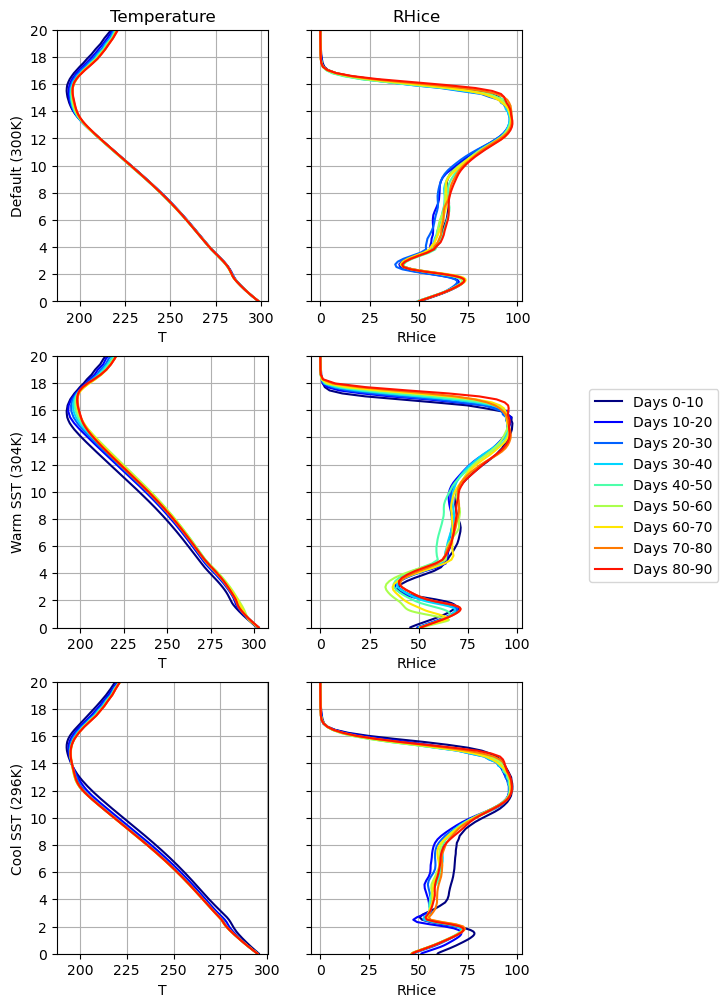

In [15]:
# --- begin user input ---
tendaysteps=True
# --- end user input ---

savename="T_RHice{}".format(comp_name)
a = 1
if not tendaysteps:
    fig, ax = plt.subplots(1,2, figsize=(3*len(var_list),4), sharey=True)
    for i in range(len(runs)):
        print(i, run_names[i], runs[i], end="...")
        ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i]))
        z = ds.Z3.mean(dim=["time","ncol"])/1000
        dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
        print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
        nt = ndays*dtperday
        ds = ds.isel(time=slice(-nt,-1))  # K/s to K/day
        print('T', end="...")
        c=colors[i]
        ax[0].plot(ds['T'].mean(axis=(0,2)), z, color=c, alpha=a, label=run_names[i])
        ax[0].set(xlabel='T', yticks=np.arange(0,21,2), ylim=[0,20])
        ax[0].grid(True)
        print('RHice', end="...")
        rhice = util.calc_rhice(ds).mean(axis=(0,2))
        ax[1].plot(rhice, z, color=c, alpha=a, label=run_names[i])
        ax[1].set(xlabel='RHice', yticks=np.arange(0,21,2), ylim=[0,20])
        ax[1].grid(True)
        print(i+1,"of",len(runs),"done.")
    h, l = ax[0].get_legend_handles_labels()
    fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
    savename="plots/compare_runs_{}_last{}days.png".format(savename, ndays)
    print("saving to",savename)
    plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
    plt.show()
else:
    fig, ax = plt.subplots(3,2, figsize=(6,12), sharey=True)
    cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0,1,10)))
    for i in range(len(runs)):
        print(i, run_names[i], runs[i], end="...")
        ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i]))
        dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
        print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
        z = ds.Z3.mean(dim=["time","ncol"])/1000
        temp = ds['T']
        print('Calculating RHice', end='...')
        rhice = util.calc_rhice(ds)
        print(temp.shape, rhice.shape, end='...')
        print('Getting 10-day means', end='...')
        for j in range(9):
            temp_tmp = temp.isel(time=slice(j*dtperday*10,(j+1)*dtperday*10)).mean(axis=(0,2))  # mean profile over ten day periods
            rhice_tmp = rhice.isel(time=slice(j*dtperday*10,(j+1)*dtperday*10)).mean(axis=(0,2))  # mean profile over ten day periods
            c=cmap(j)
            llab = 'Days {}-{}'.format(str(j*10),str((j+1)*10))
            ax[i,0].plot(temp_tmp, z, color=c, alpha=a, label=llab)
            ax[i,0].set(xlabel='T', yticks=np.arange(0,21,2), ylim=[0,20])
            ax[i,0].grid(True)
            ax[i,1].plot(rhice_tmp, z, color=c, alpha=a, label=llab)
            ax[i,1].set(xlabel='RHice', yticks=np.arange(0,21,2), ylim=[0,20])
            ax[i,1].grid(True)
            print(j, end='...')
        print(i+1,"of",len(runs),"done.")
    h, l = ax[0,0].get_legend_handles_labels()
    fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
    ax[0,0].set(ylabel=run_names[0], title='Temperature')
    ax[0,1].set(title='RHice')
    ax[1,0].set(ylabel=run_names[1])
    ax[2,0].set(ylabel=run_names[2])
    savename="plots/compare_runs_{}_10daymeans.png".format(savename, ndays)
    print("saving to",savename)
    plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
    plt.show()


# Histogram of variable of your choice

We make a histogram of the variable of your choice over the last ```ndays``` of the simulation. 
Typically, we are interested in total column water (integrated water vapor) ```TMQ``` or total cloud condensate (ice water path) ```TGCLDIWP``` or precipitation ```PRECL```.
The mean values are written in the legend for each simulation.

I've enabled the options for plotting:
- ```var``` which 2D variable to plot: May choose from ```TMQ```, ```TGCLDIWP```, ```PRECL``` for built-in functioning. If you choose another variable you should manually adjust the ```unit_fac``` to get the appropriate units for plotting.

0 Default (300K) f_default...dt per day 8 or 3 hourly output... 240 2000-03-02 03:00:00 2000-03-31 21:00:00...TMQ...1 of 3 done.
1 Warm SST (304K) j_304K...dt per day 4 or 6 hourly output... 120 2000-03-02 12:00:00 2000-04-01 00:00:00...TMQ...2 of 3 done.
2 Cool SST (296K) j_296K...dt per day 4 or 6 hourly output... 120 2000-03-02 12:00:00 2000-04-01 00:00:00...TMQ...3 of 3 done.
saving to plots/compare_runs_hist_TMQ_sst.png


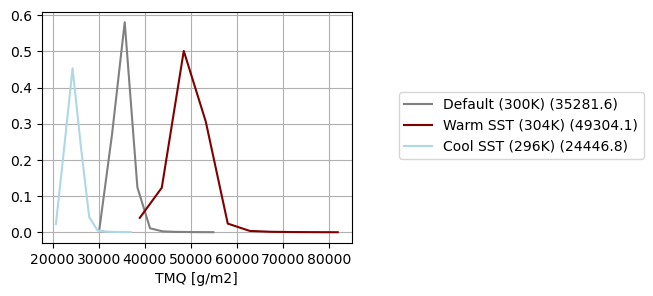

In [17]:
# --- begin user input ---
var = "TMQ"
# ---
if var==("TMQ" or "TGCLDIWP"):
    unit_fac = 1000  # 1000 for IWP/TMQ [g/m2];
elif var=="PRECL":
    unit_fac = 1000*3600*24  # for PR [mm/day];
fig, ax = plt.subplots(1,1, figsize=(4,3))
savename="hist_"+var+"_"+comp_name
for i in range(len(runs)):
    print(i, run_names[i], runs[i], end="...")
    # ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    # z = ds.Z3.mean(dim=["time","ncol"])
    ds = xr.open_dataset(run_dir+"/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i]))
    dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
    print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
    nt = ndays*dtperday
    ds = ds.isel(time=slice(-nt,-1))  # 2D variabels are output hourly
    print(nt, ds.time[0].values,ds.time[-1].values, end="...")
    c = colors[i]
    a = 1
    print(var, end="...")
    mean_val = np.nanmean(ds[var])*unit_fac
    if var=="TGCLDIWP":
        bins=np.logspace(-4,4,40)
    elif var=="PRECL":
        bins=np.linspace(0,2,25)
    else:
        bins=12
    var_hist, bin_edges = np.histogram(ds[var]*unit_fac,
                                       bins=bins)
    var_hist = var_hist/np.prod(ds[var].shape)
    bin_mids = (bin_edges[1:]+bin_edges[:-1])/2
    ax.plot(bin_mids, var_hist, color=c, alpha=a,
            label="{} ({:.1f})".format(run_names[i], mean_val))
    if var=="PRECL":
        units = "mm/day"
    elif var=="TGCLDIWP" or var=="TMQ":
        units = ds[var].units[1:]
    else:
        units = ds[var].units
    ax.set(xlabel="{} [{}]".format(var, units),
           # xscale="log"
          )
    ax.grid(True)
    print(i+1,"of",len(runs),"done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename)
print("saving to",savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()

# Extra/old plots

## Plot for AMS annual meeting 2024 | Baltimore, MD

Plotting cloud fraction, all sky IWC, ice number, and relative humidity wrt ice.

No user input.

0 f_default...calculating all sky...plotting...1/4 done
1 g_halfsed...calculating all sky...plotting...2/4 done
2 g_2xsed...calculating all sky...plotting...3/4 done
3 g_halfdep...calculating all sky...plotting...4/4 done
4 g_2xdep...calculating all sky...plotting...5/4 done
saving to plots/compare_runs_forAMS24mtg_IWC_1e-08_small.png


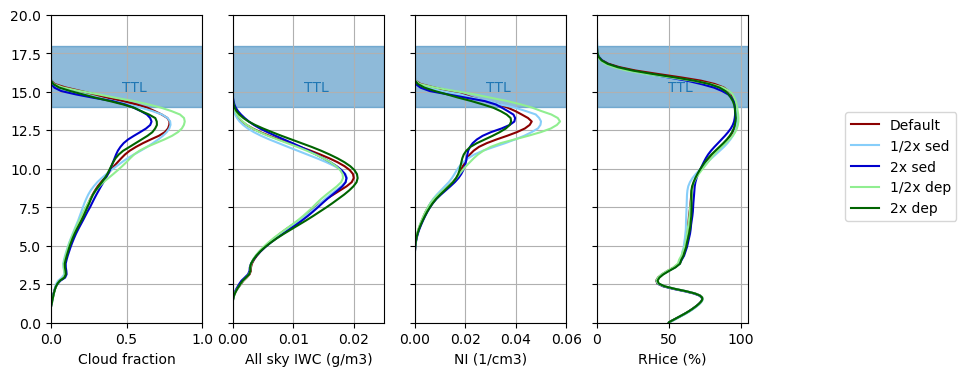

In [5]:
# plot for AMS 24 meeting
# cloud fraction, all sky IWC, NI

fig, ax = plt.subplots(1,4, figsize=(9,4))
xmaxs = [1, 0.025, 0.06, 105]
qsmall = 1e-8 #kg/kg
incld = False
if incld:
    savename = "forAMS24mtg_incld_IWC_{}_{}".format(str(qsmall), comp_name)
else:
    savename = "forAMS24mtg_IWC_{}_{}".format(str(qsmall), comp_name)
for i in range(len(runs)):
    print(i, runs[i], end="...")
    # get cloud fraction
    file = run_dir+"/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
    dtperday = np.argmin((abs(ds.time.dt.day - ds.time.dt.day[0].values - 1)).values)
    print("dt per day", dtperday, "or", 24//dtperday, "hourly output", end='... ')
    nt = ndays*dtperday
    ds = xr.open_dataset(file).isel(time=slice(-nt,-1))
    z = ds.Z3.mean(dim=["time","ncol"])/1000
    # defined by qsmall QI 
    cld_frac = np.mean(np.where(ds.CLDICE>qsmall,1,0), axis=(0,2))
    if incld:
        print("calculating in-cld... iwc",end="...")
        iwc = ds.IWC.where(ds.CLDICE>qsmall).mean(axis=(0, 2))
        print("ni",end="...")
        ni = (calc_ni(ds.NUMICE.where(ds.CLDICE>qsmall), ds.Q, ds.lev*100, 
                      ds['T'])/1e6).assign_attrs({'long_name':'icnc', 'units':'cm-3'}).mean(dim=["time", "ncol"])
        print("RHice",end="...")
        rhice = calc_rhice(ds.where(ds.CLDICE>qsmall)).mean(dim=["time", "ncol"])
    else:
        print("calculating all sky",end="...")
        iwc = ds.IWC.mean(dim=["time", "ncol"])
        ni = (calc_ni(ds.NUMICE, ds.Q, ds.lev*100, 
                      ds['T'])/1e6).mean(dim=["time", "ncol"])
        rhice = calc_rhice(ds).mean(dim=["time", "ncol"])
    c = colors[i]
    a = 1
    # plot cld fraction, iwc, ni
    print("plotting...", end="")
    ax[0].plot(cld_frac, z, color=c, alpha=a, label=run_names[i])
    ax[1].plot(iwc*1000, z, color=c, alpha=a)
    ax[2].plot(ni, z, color=c, alpha=a)
    ax[3].plot(rhice, z, color=c, alpha=a)
    print(str(i+1)+"/4 done")

# label it!
ax[0].set_xlabel("Cloud fraction")
ax[1].set_xlabel("All sky IWC (g/m3)")
ax[2].set_xlabel("NI (1/cm3)")
ax[3].set_xlabel("RHice (%)")


for j in range(4):
    ax[j].grid(True)
    ax[j].fill_between([0, xmaxs[j]], 14, 18, color="C0", alpha=0.5)
    ax[j].annotate("TTL", color="C0", xy=(0.47, 0.75), xycoords="axes fraction")
    ax[j].set_ylim([0, 20])
    ax[j].set_xlim([0, xmaxs[j]])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
ax[3].set_yticklabels([])
# ax[2].tick_params(labelrotation=20)
fig.legend(loc=6, bbox_to_anchor=(1.0, 0.5))
print("saving to plots/compare_runs_{}.png".format(savename))
plt.savefig("plots/compare_runs_{}.png".format(savename),
            dpi=120, bbox_inches="tight", pad_inches=1)
plt.show()

## Cloud top height

Find the cloud top height and index for each column over time and save as a new variable in the xarray (using different cloud thresholds as labeled).

Then save as a new netcdf dataset.

Then plot a histogram of cloud top height.

In [13]:
# cloud top height vs olr
run = "f_default"
file = run_dir+"/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run)
ds = xr.open_dataset(file).isel(time=slice(-nt, -1))
z = ds.Z3/1000
cldice = ds.CLDICE  # kg/kg
thres = 1e-7  # kg/kg
print(z.shape)

# initialize arrays to zeros
cldtopheight = np.zeros(z[:, 0].shape)
cldtopind = np.zeros(z[:, 0].shape)
# find cloud top height
for l in range(0, len(ds.lev)-1):
    print(l, z[0,l,0].values)
    cldtopheight = np.where((cldtopheight==0)&(cldice.isel(lev=l)>thres), z[:,l], cldtopheight)
    cldtopind = np.where((cldtopind==0)&(cldice.isel(lev=l)>thres), l, cldtopind)
da = xr.DataArray(cldtopheight, dims=["time", "ncol"], coords={"time":ds.time, "ncol":ds.ncol}, 
                  attrs={"name":"cloud top height", "units":"m", "thres":thres})
daind = xr.DataArray(cldtopind, dims=["time", "ncol"], coords={"time":ds.time, "ncol":ds.ncol}, 
                     attrs={"name":"cloud top height index", "units":"index", "thres":thres})
ds = ds.assign({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind})
ds

(240, 128, 1296)
0 41.179268
1 39.583706
2 38.25068
3 37.033104
4 35.78685
5 34.52122
6 33.335358
7 32.262398
8 31.21032
9 30.149288
10 29.131271
11 28.200037
12 27.317347
13 26.439482
14 25.584661
15 24.795086
16 24.067938
17 23.366684
18 22.686987
19 22.04808
20 21.459383
21 20.904043
22 20.374216
23 19.874517
24 19.411837
25 18.984457
26 18.588636
27 18.220537
28 17.876879
29 17.56435
30 17.288551
31 17.043745
32 16.819319
33 16.600872
34 16.380507
35 16.15733
36 15.936851
37 15.7210455
38 15.504073
39 15.283318
40 15.062861
41 14.846369
42 14.629581
43 14.408632
44 14.185839
45 13.96679
46 13.748987
47 13.526158
48 13.298856
49 13.07303
50 12.84914
51 12.61954
52 12.3828125
53 12.145148
54 11.909652
55 11.671037
56 11.426178
57 11.178667
58 10.9335
59 10.686907
60 10.433746
61 10.175995
62 9.920441
63 9.665394
64 9.40385
65 9.136012
66 8.868601
67 8.603295
68 8.333138
69 8.056246
70 7.7778883
71 7.50216
72 7.223713
73 6.9384446
74 6.649959
75 6.3647175
76 6.0789194
77 5.7859983
78 

<xarray.Dataset>
Dimensions:                   (ncol: 1296, lev: 128, ilev: 129, swband: 14,
                               lwband: 16, P3_input_dim: 16, P3_output_dim: 32,
                               time: 240, nbnd: 2)
Coordinates:
  * lev                       (lev) float64 2.58 3.23 3.88 ... 991.0 994.9 998.5
  * ilev                      (ilev) float64 2.255 2.905 3.555 ... 997.0 1e+03
  * swband                    (swband) float64 2.925e+03 3.625e+03 ... 1.71e+03
  * lwband                    (lwband) float64 130.0 375.0 ... 2.965e+03
  * P3_input_dim              (P3_input_dim) int32 1 2 3 4 5 ... 12 13 14 15 16
  * P3_output_dim             (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                      (time) object 2000-03-02 00:00:00 ... 2000-03-3...
  * ncol                      (ncol) int64 0 1 2 3 4 ... 1292 1293 1294 1295
Dimensions without coordinates: nbnd
Data variables: (12/225)
    lat                       (ncol) float64 ...
    lon                       (ncol) float64 ...
    area                      (ncol) float64 ...
    hyam                      (lev) float64 ...
    hybm                      (lev) float64 ...
    P0                        float64 ...
    ...                        ...
    hstobie_linoz             (time, lev, ncol) float32 ...
    liq_ice_exchange          (time, lev, ncol) float32 ...
    vap_ice_exchange          (time, lev, ncol) float32 ...
    vap_liq_exchange          (time, lev, ncol) float32 ...
    cldtop_height1e-07        (time, ncol) float64 13.97 13.97 ... 15.07 15.07
    cldtop_ind1e-07           (time, ncol) float64 45.0 45.0 46.0 ... 40.0 40.0
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         028f43941a
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_3

In [ ]:

ds.to_netcdf(file)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
hist, xedges, yedges = np.histogram2d(olr.values.flatten(), 
                                      cldtopheights.values.flatten(), 
                                      bins=[np.linspace(80,310,25), 
                                            np.arange(0,20000,1000)]
                                     )
hist = hist/len(olr.values.flatten())
xmids = (xedges[1:]+xedges[:-1])/2
ymids = (yedges[1:]+yedges[:-1])/2
cf = plt.contourf(xmids, ymids, hist, levels=np.arange(-3.4,-1.2,0.2), cmap="gist_earth_r")
plt.colorbar(cf)
plt.show()

## compare two runs 2D variables in water or radiation

In [ ]:
# 2D comparisons (like in comp_rcemip)
# --- begin user input ---
plot_type="water"  # options: "rad" for radiation, "water" for hydrometeors
plot=False
runs2 = ["g_halfsed","g_2xsed"]
run_names2 = ["1/2x sed", "2x sed"]
# --- end user input ---
if plot:
    var_list_rad = ["RSFC", "RSFCC","RTOA","RTOAC","RNET","RNETC","OLR","ASR","QOCN","LHF","SHF"]
    var_list_water = ["PW","PR","LWP","IWP","WVP"]
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    savename=plot_type+"_"
    for i in range(len(runs2)):
        ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h1.2000-01-01-00000.nc".format(runs[i],runs[i]))
        ds = ds.isel(time=slice(-nt, -1))
        var_dict = {}
        savename = savename + runs2[i][-3:] + "-"
        if plot_type=="rad":
            # rsfc, the net radiative flux at the sfc (SW-LW)
            var_dict["RSFC"] = (ds["FSNS"]-ds["FLNS"]).mean()
            var_dict["RSFCC"] = (ds["FSNSC"]-ds["FLNSC"]).mean()
            # rtoa, the net radiative flux at toa (SW-LW)
            var_dict["RTOA"] = (ds["FSNTOA"]-ds["FLUT"]).mean()
            var_dict["RTOAC"] = (ds["FSNTOAC"]-ds["FLUTC"]).mean()
            # rnet = rtoa − rsfc, where negative values indicate net atmospheric radiative cooling
            var_dict["RNET"] = ((ds["FSNTOA"]-ds["FLUT"]) - (ds["FSNS"]-ds["FLNS"])).mean()
            var_dict["RNETC"] = ((ds["FSNTOAC"]-ds["FLUTC"]) - (ds["FSNSC"]-ds["FLNSC"])).mean()
            # olr
            var_dict["OLR"] = ds["FLUT"].mean()
            # asr, absorbed sw radiation (i.e., net SW flux at TOA (total incoming - total outgoing))
            var_dict["ASR"] = ds["FSNTOA"].mean()
            # energy input into ocean
            var_dict["QOCN"] = ((ds["FSNS"]-ds["FLNS"])-ds["LHFLX"]-ds["SHFLX"]).mean()
            # lhf, latent heat flux
            var_dict["LHF"] = ds["LHFLX"].mean()
            # shf, sensible heat flux
            var_dict["SHF"] = ds["SHFLX"].mean()
            units_dict = zip(var_list_rad,["W/m2"]*len(var_list_rad))
        else: #plot_type=="water"
            # pw, precipitable water
            var_dict["PW"] = ds["TMQ"].mean()
            # precip, precipitation rate
            var_dict["PR"] = ((ds.PRECL)*1000*3600*24).mean() #m/s --> mm/day ==> m/s * 1000 mm/m * 3600s/1hr * 24hr/day = mm/day
            # LWP, liquid water path
            var_dict["LWP"] = ds["TGCLDLWP"].mean()
            # IWP, ice water path
            var_dict["IWP"] = ds["TGCLDIWP"].mean()
            # clwvi_avg, water vapor path
            var_dict["WVP"] = ds["TGCLDCWP"].mean()
            units_dict = zip(var_list_water,["kg/m2","mm/day","kg/m2","kg/m2","kg/m2"])
        # plot
        if plot_type=="rad":
            var_list=var_list_rad
        else:
            var_list=var_list_water
            if i==0:
                axt = ax.twinx()
        for j in range(len(var_list)):
            ci = "C0" if i==0 else "C1"
            if j==0:
                ax.bar(j+(i/len(runs2)),var_dict[var_list[j]], color=ci, width=0.5, label=run_names2[i])
            else:
                if (plot_type=="water") & (j>1):
                    axt.bar(j+(i/len(runs2)),var_dict[var_list[j]], color=ci, width=0.5)
                    axt.set_yscale("log")
                    axt.axvline(1.75, color='k')
                    axt.set_ylim([1e-2,3e-1])
                else:
                    ax.bar(j+(i/len(runs2)),var_dict[var_list[j]], color=ci, width=0.5)
    ax.set_xticks(np.arange(0.25,len(var_list),1), var_list)
    ax.set_xticks(np.arange(-0.25,len(var_list),1), minor=True)
    ax.tick_params(axis='x', labelrotation=30)
    ax.legend(loc=3)
    ax.grid(axis='x', which='minor')
    print("save as plots/compare_runs_{}.png".format(savename[:-1]))
    plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]))
    plt.show()